# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/")
import CommonUtils as cu

### Define constants and starting fit parameters

In [2]:
bin_w = 150*1e-3 # 150 ns 
x_min = 0 # us  #TODO 30 for data 
x_max = 500 # us 
p_min = 1700 # MeV 
print("Starting and end times [us]:", x_min, x_max)
print("P cut [MeV]:", p_min)

omega_a = 1.44 # MHz (magic)
gm2_f = 0.23 # MHz
g2period = 2*np.pi / omega_a   # 4.36 us 

phase=6.240
print("Using derived phase of [rad]", phase)

gm2_asym = 0.45 
ang_amp = 1.0
cos_amp = 1. / np.sqrt(2)
sin_amp = np.sqrt(1 - np.power(cos_amp, 2))
p0_ver=(ang_amp, cos_amp, omega_a, phase, sin_amp)

Starting and end times [us]: 0 500
P cut [MeV]: 1700
Using derived phase of [rad] 6.24


### Define fit functions

In [3]:
def f_vertical(t, *pars):
    N=pars[0]
    A_w=pars[1]
    omega=pars[2]
    phi=pars[3]
    A_edm=pars[4]
    return N*( A_w*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi))


### Load HDF5 data and apply time and momentum cuts

In [4]:
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )
mom_cut = (data['trackMomentum'] > p_min) # MeV  
time_cut = (data['trackT0'] > x_min) # MeV  
data=data[mom_cut & time_cut]

#define station cuts to loop over
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

### Resolve variables

In [5]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y = np.arctan2(py, p)
data['mod_times']=mod_times
data['theta_y']=theta_y
N=data.shape[0] 
data

,trackT0,station,trackMomentum,trackMomentumY,mod_times,theta_y
2,80.277852,18,2544.615967,-59.835049,1.738035,-0.023510
3,42.755086,0,2182.920654,15.766864,3.485178,0.007223
6,10.879105,12,2120.369385,-8.798045,2.152459,-0.004149
18,11.418941,0,2252.512695,1.755878,2.692295,0.000780
20,204.562281,18,2131.132812,-22.711870,3.849417,-0.010657
...,...,...,...,...,...,...
5483788,33.120555,12,2171.714844,12.780183,2.577293,0.005885
5483789,82.543117,12,1940.134521,43.934719,4.003301,0.022641
5483790,2.854671,18,1702.657715,-9.733911,2.854671,-0.005717
5483793,21.286004,18,1840.056641,-38.210846,3.832711,-0.020763


### Digitise data

In [6]:
count_binw=0.01 # us 
count_xmin=0
count_xmax=g2period
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, count_binw, (count_xmin, count_xmax) )
y_err = np.sqrt(freq)

### Plot counts vs. mod time and fit

In [7]:
#set vars, fit pars, and fot
x,y,y_e = bin_c, freq, y_err
p0=[1e3, 1e4, -0.4, 1.44, 6.24]
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_function, p0)

Params: [ 3.822e+03  1.307e+02 -3.548e-01  1.422e+00  6.387e+00]
Errors: [2.047e+01 3.542e+01 2.162e-03 8.043e-03 2.057e-02]
𝝌2/dof=1.95


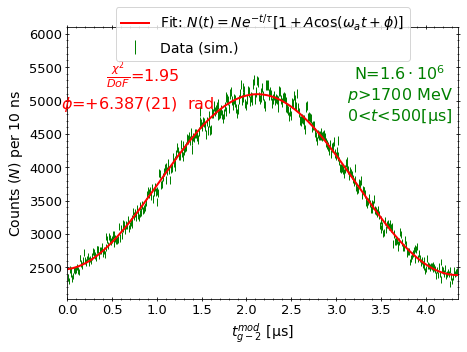

In [8]:
font_size=14
fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(count_binw*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_function(bin_c, *par), c="red", 
        label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.15);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$\phi$", par[4], par_e[4], " rad", prec=3)
leg_data="N="+cu.sci_notation(N)+"\n"+r"$p$>"+str(p_min)+" MeV\n"+str(x_min)+r"<$t$<"+str(x_max)+r"$\mathrm{[\mu}$s]"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.18, 0.75, leg_fit, c="r", fs=font_size+2)
cu.textL(ax, 0.85, 0.75, leg_data, fs=font_size+2)
fig.savefig("../fig/bnl_fit.png", dpi=300)

### Profile the $\langle\theta_y\rangle$, fit and plot

In [9]:
df_binned =cu.Profile(mod_times, theta_y, None, nbins=100, xmin=np.min(mod_times), xmax=np.max(mod_times), mean=True, only_binned=True)
x=df_binned['bincenters']
y=df_binned['ymean']*1e3
y_e=df_binned['yerr']*1e3
x_e=df_binned['xerr']

In [10]:
p0=[0.00, 0.14, 0.06, 1.44]
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, p0)

Params: [-0.013  0.166  0.058  1.334]
Errors: [0.034 0.015 0.013 0.096]
𝝌2/dof=1.06


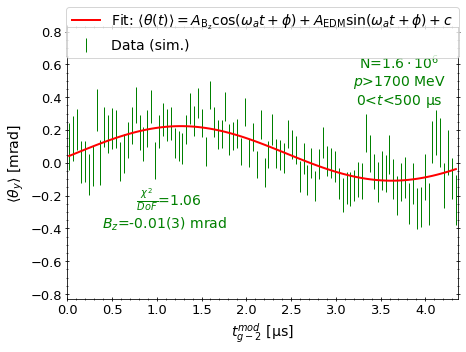

In [11]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", font_size=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad]")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), color="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*2.0, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+r"$p$>"+str(p_min)+" MeV\n"+str(x_min)+r"<$t$<"+str(x_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.85, 0.8, leg_data, font_size=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$B_z$", par[0], par_e[0], "mrad")
cu.textL(ax, 0.25, 0.3, leg_fit, font_size=font_size, )
fig.savefig("../fig/bz_fit.png", dpi=300)